In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial']
%config InlineBackend.figure_formats = ['svg']

In [4]:
import numpy as np
import cf.counterfactual as cf
import cf.utils as utils
import pandas as pd
import pickle
import itertools as it
from tqdm import tqdm
import scipy.sparse

# Sepsis Simulator code
from sepsisSimDiabetes.State import State
from sepsisSimDiabetes.Action import Action
from sepsisSimDiabetes.DataGenerator import DataGenerator
import sepsisSimDiabetes.MDP as simulator 

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
import joblib

In [6]:
output_dir = '../datagen/vaso_eps_0_1-100k/'

import pathlib
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
NSIMSAMPS = 100_000  # Samples to draw from the simulator
NSTEPS = 20  # Max length of each trajectory
# DISCOUNT_Pol = 0.99 # Used for computing optimal policies
# DISCOUNT = 1 # Used for computing actual reward

PROB_DIAB = 0.2

# # Option 1: Use bootstrapping w/replacement on the original NSIMSAMPS to estimate errors
# USE_BOOSTRAP=True
# N_BOOTSTRAP = 100

# # Option 2: Use repeated sampling (i.e., NSIMSAMPS fresh simulations each time) to get error bars; 
# # This is done in the appendix of the paper, but not in the main paper
# N_REPEAT_SAMPLING = 1

# # These are properties of the simulator, do not change
n_actions = Action.NUM_ACTIONS_TOTAL
# n_components = 2

In [8]:
optPol = joblib.load('../data/π_star.joblib')

In [9]:
# vaso eps=0.1, mv abx optimal
behaviorPol = (np.tile(optPol.reshape((-1,2,2,2)).sum(axis=3, keepdims=True), (1,1,1,2)).reshape((-1, 8)) / 2)
behaviorPol[optPol == 1] = 0.9
behaviorPol[behaviorPol == 0.5] = 0.1

In [10]:
behaviorPol

array([[0.9, 0.1, 0. , ..., 0. , 0. , 0. ],
       [0.9, 0.1, 0. , ..., 0. , 0. , 0. ],
       [0.9, 0.1, 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.9, 0.1, 0. , ..., 0. , 0. , 0. ],
       [0.9, 0.1, 0. , ..., 0. , 0. , 0. ],
       [0.9, 0.1, 0. , ..., 0. , 0. , 0. ]], shape=(1442, 8))

In [11]:
def conv_to_np(this_list):
    this_arr = np.array(this_list)[:, np.newaxis]
    # Make this idempotent
    this_arr = this_arr.squeeze()[:, np.newaxis]
    return this_arr

In [12]:
# Generate 2 batches of data with N episodes each
for it in [1, 2]:
    print('Iteration:', it, flush=True)
    np.random.seed(it)
    dgen = DataGenerator()
    states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
       NSIMSAMPS, NSTEPS, policy=behaviorPol[:-2], policy_idx_type='full', output_state_idx_type='full',
       p_diabetes=PROB_DIAB, modified=True, use_tqdm=True) #True, tqdm_desc='Behaviour Policy Simulation')

    obs_samps = utils.format_dgen_samps(
       states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

    df_samp_list = []
    infos = []
    for i in range(NSIMSAMPS):
        pt_id = i + it*NSIMSAMPS
        df_i, (len_i, y_i) = utils.df_from_samps(obs_samps, i, get_outcome=True, is_full=True)
        df_i['pt_id'] = pt_id
        df_i['Diabetic'] = diab[i][:len_i+1]
        df_i['State_idx'] = states[i][:len_i+1]
        df_i['Obs_idx'] = df_i['State_idx'].apply(lambda s: State(state_idx=s, idx_type='full').get_state_idx('obs'))
        df_i['Proj_idx'] = df_i['State_idx'].apply(lambda s: State(state_idx=s, idx_type='full').get_state_idx('proj_obs'))
        df_i['Action'] = actions[i][:len_i+1]
        df_i['Reward'] = 0
        df_i.loc[len_i, 'Reward'] = y_i
        df_i = df_i.set_index('pt_id').reset_index()
        df_samp_list.append(df_i)
        infos.append([pt_id, diab[i][0], y_i, len_i, len(df_i)])

    df_samps = pd.concat(df_samp_list).astype(int)
    df_features = pd.get_dummies(df_samps, columns=['Diabetic', 'Heart Rate', 'SysBP', 'Percent O2', 'Glucose', 'Treat: AbX', 'Treat: Vaso', 'Treat: Vent'])
    df_samps_info = pd.DataFrame(infos, columns=['pt_id', 'Diabetic', 'Outcome', 'Steps', 'Length']).astype(int)
    
    assert df_samps.shape[1] == 15
    assert df_features.shape[1] == 28
    assert df_samps_info.shape[1] == 5
    df_samps.to_csv('{}/{}-samples.csv'.format(output_dir, it), index=False)
    df_features.to_csv('{}/{}-features.csv'.format(output_dir, it), index=False)
    df_samps_info.to_csv('{}/{}-info.csv'.format(output_dir, it), index=False)
    joblib.dump([states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals], '{}/{}-alldata.joblib'.format(output_dir, it))
    joblib.dump(obs_samps, '{}/{}-obs_samps.joblib'.format(output_dir, it))

Iteration: 1


Iteration: 2


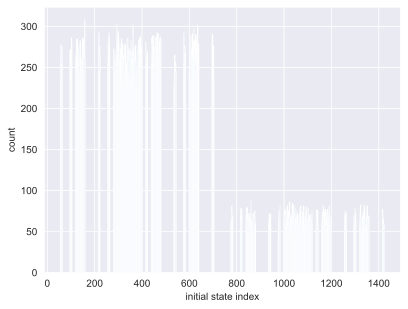

In [13]:
plt.bar(range(1440), df_samps.groupby('pt_id').first()['State_idx'].value_counts().reindex(range(1440)))
plt.xlabel('initial state index')
plt.ylabel('count')
plt.show()

# Features

In [14]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from collections import defaultdict
import pickle
import itertools
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
import joblib
from joblib import Parallel, delayed

In [16]:
import scipy.sparse

## 21-dimensional state features

In [17]:
nS, nA = 1442, 8
d = 21

In [18]:
def get_state_action_feature(x_s, a):
    x_sa = np.zeros((nA, d))
    x_sa[a, :] = x_s
    return x_sa.flatten()

In [19]:
def make_features_single_trajectory(df_i):
    # Initial timestep
    s_init = df_i.iloc[0, 7:28].values
    x_s_init = np.array(s_init)
    xa_s_init_all = np.array([get_state_action_feature(x_s_init, a_) for a_ in range(nA)])

    # Intermediate timestep
    if len(df_i) > 1:
        s = df_i.iloc[:-1, 7:28].values
        a = df_i.iloc[:-1]['Action'].values
        r = df_i.iloc[:-1]['Reward'].values
        s_next = df_i.iloc[1:, 7:28].values

        n = len(s)
        x_s = np.array(s)
        xa_sa = np.array([get_state_action_feature(x_s[j, :], a[j]) for j in range(n)])

        x_s_next = np.array(s_next)
        xa_s_next_all = np.vstack([
            np.vstack([get_state_action_feature(x_s_next[j], a_) for a_ in range(nA)]) 
            for j in range(n)
        ])
    else:
        x_s = np.array((0, d))
        a = np.zeros((0), dtype=int)
        xa_sa = np.array((0, d*nA))
        r = np.zeros((0))
        x_s_next = np.array((0, d))
        xa_s_next_all = np.array((0, d*nA))

    # Final timestep
    s_last = df_i.iloc[-1, 7:28].values
    a_last = df_i.iloc[-1]['Action']
    r_last = df_i.iloc[-1]['Reward']
    if r_last == -1 or r_last == 1:
        # Reached death/disch states
        # every action leads to reward
        x_s_last = np.array(s_last)
        xa_s_last_all = np.array([get_state_action_feature(x_s_last, a_) for a_ in range(nA)])
        r_last_all = np.array(nA * [r_last])

        xa_out = np.vstack([xa_sa, xa_s_last_all])
        xa_next_out = np.vstack([xa_s_next_all, np.zeros((nA*nA, nA*d))])
        r_out = np.concatenate([r, r_last_all])

        a_out = np.concatenate([a, (list(range(nA)))])
        x_out = np.vstack([x_s, *(nA*[x_s_last])])
        x_next_out = np.vstack([x_s_next, np.zeros((nA, d))])
    else: 
        # terminated early due to max length, so no next state information
        xa_out = xa_sa
        xa_next_out = xa_s_next_all
        r_out = r

        x_out = x_s
        a_out = a
        x_next_out = x_s_next
    
    return x_s_init, xa_s_init_all, x_out, a_out, xa_out, r_out, x_next_out, xa_next_out

In [23]:
import gc  # For manual garbage collection
import scipy

batch_size = 1000  # Adjust: smaller for low RAM (e.g., 500), larger for more (e.g., 2000)
for it in [1, 2]:
    df_features = pd.read_csv('{}/{}-features.csv'.format(output_dir, it))
    pt_groups = list(df_features.groupby('pt_id'))  # List of (pt_id, df_group)
    num_batches = (len(pt_groups) + batch_size - 1) // batch_size

    # Initialize accumulators
    all_X_init, all_Xa_init, all_X, all_A, all_Xa, all_R, all_X_next, all_Xa_next = [], [], [], [], [], [], [], []
    all_lengths = []
    current_inds_init = [0]  # Cumulative start indices

    for batch_idx in tqdm(range(num_batches), desc=f"Processing batches for it={it}"):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(pt_groups))
        batch_groups = pt_groups[start_idx:end_idx]

        # Process batch: Fixed unpack - for _, df_i in batch_groups (ignores pt_id key)
        batch_out = [make_features_single_trajectory(df_i) for _, df_i in batch_groups]
        batch_X_init, batch_Xa_init, batch_X, batch_A, batch_Xa, batch_R, batch_X_next, batch_Xa_next = zip(*batch_out)

        # Append to accumulators (vstack per batch)
        all_X_init.append(np.vstack(batch_X_init))
        all_Xa_init.append(np.vstack(batch_Xa_init))
        all_X.append(np.vstack(batch_X))
        all_Xa.append(np.vstack(batch_Xa))
        all_A.extend(batch_A)  # 1D concat
        all_R.extend(batch_R)
        all_X_next.append(np.vstack(batch_X_next))
        all_Xa_next.append(np.vstack(batch_Xa_next))

        # Track lengths (from X per trajectory, as in original)
        batch_lengths = [len(x_i) for x_i in batch_X]  # len of each state's steps
        all_lengths.extend(batch_lengths)
        # Update cumulative inds_init (sum lengths up to current batch)
        current_inds_init.append(current_inds_init[-1] + sum(batch_lengths))

        # Clear batch vars
        del batch_out, batch_X_init, batch_Xa_init, batch_X, batch_A, batch_Xa, batch_R, batch_X_next, batch_Xa_next, batch_lengths
        gc.collect()

    X_init = np.vstack(all_X_init)
    Xa_init = np.vstack(all_Xa_init)
    X = np.vstack(all_X)
    Xa = np.vstack(all_Xa)
    A = np.concatenate(all_A)
    R = np.concatenate(all_R)
    X_next = np.vstack(all_X_next)
    Xa_next = np.vstack(all_Xa_next)

    print(Xa_init.shape, Xa.shape, Xa_next.shape, R.shape)
    print(X_init.shape, X.shape, A.shape, R.shape, X_next.shape)

    # Check dtypes (debug: add this to confirm issue)
    print("Sample dtypes:", X_init.dtype, X.dtype, X_next.dtype)  # Likely 'O' for object

    # Store indices
    lengths = all_lengths
    inds_init = np.cumsum([0] + lengths)

    # Save dense version (unchanged, already works)
    joblib.dump({
        'X_init': X_init, 'X': X, 'A': A, 'R': R, 'X_next': X_next,
        'Xa_init': Xa_init, 'Xa': Xa, 'Xa_next': Xa_next,
        'lengths': lengths, 'inds_init': inds_init,
    }, '{}/{}-21d-feature-matrices.joblib'.format(output_dir, it))

    # Fix for sparse: Convert 2D matrices to float64 before sparse
    X_init_sp = X_init.astype(np.float64)
    X_sp = X.astype(np.float64)
    X_next_sp = X_next.astype(np.float64)
    Xa_init_sp = Xa_init.astype(np.float64)
    Xa_sp = Xa.astype(np.float64)
    Xa_next_sp = Xa_next.astype(np.float64)

    # Save sparse version (now with fixed dtypes)
    joblib.dump({
        'X_init': scipy.sparse.csr_matrix(X_init_sp), 'X': scipy.sparse.csr_matrix(X_sp), 'A': A, 'R': R, 'X_next': scipy.sparse.csr_matrix(X_next_sp),
        'Xa_init': scipy.sparse.csr_matrix(Xa_init_sp), 'Xa': scipy.sparse.csr_matrix(Xa_sp), 'Xa_next': scipy.sparse.csr_matrix(Xa_next_sp),
        'lengths': lengths, 'inds_init': inds_init,
    }, '{}/{}-21d-feature-matrices.sparse.joblib'.format(output_dir, it))

    print("Dtypes after fix:", X_init_sp.dtype)  # Should be float64

    # Cleanup (add the fixed vars to del)
    del all_X_init, all_Xa_init, all_X, all_A, all_Xa, all_R, all_X_next, all_Xa_next, all_lengths, X_init, Xa_init, X, A, Xa, R, X_next, Xa_next
    del X_init_sp, X_sp, X_next_sp, Xa_init_sp, Xa_sp, Xa_next_sp  # Extra cleanup
    gc.collect()
    print(f"Completed it={it}, both dense and sparse saved. Memory cleared.")

Processing batches for it=1: 100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


(800000, 168) (1724475, 168) (13795800, 168) (1724475,)
(100000, 21) (1724475, 21) (1724475,) (1724475,) (1724475, 21)
Sample dtypes: object object float64
Dtypes after fix: float64
Completed it=1, both dense and sparse saved. Memory cleared.


Processing batches for it=2: 100%|██████████| 100/100 [03:37<00:00,  2.18s/it]


(800000, 168) (1723214, 168) (13785712, 168) (1723214,)
(100000, 21) (1723214, 21) (1723214,) (1723214,) (1723214, 21)
Sample dtypes: object object float64
Dtypes after fix: float64
Completed it=2, both dense and sparse saved. Memory cleared.
